In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_GenText
from inter.simpleInteraction import simpleInteraction as inter

from outil import *

# Environement
Nous prennons un environnement pour obtenir les tokens que nous voulons générer

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


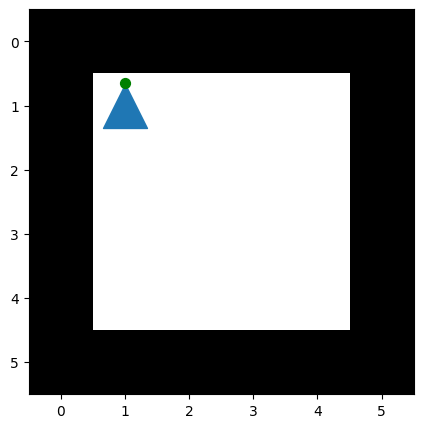

In [2]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

# Liste vocab
Nous pouvons maintenant définir notre liste de vocabulaire et notre tokenizer

In [3]:
list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)
# Test tokenizer
# print(tokenizer.encode(("forward", "empty")))
# print(tokenizer.encode("<pad>"))

<pad>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, ('forward', 'wall'): 1, ('forward', 'empty'): 2, ('turn_left', 'empty'): 3, ('turn_right', 'empty'): 4, ('feel_front', 'wall'): 5, ('feel_front', 'empty'): 6, ('feel_left', 'wall'): 7, ('feel_left', 'empty'): 8, ('feel_right', 'wall'): 9, ('feel_right', 'empty'): 10}


# Génération de texte
## Entrainement ?

Dans notre cas nous n'avons pas de données au début, l'agent n'a pas encore intéragit avec son environement. Donc nous n'avons pas de train possible.

## Prompt
Mais pour que le LSTM génére du texte il nous faut un prompt. Pour se faire nous avons plusieurs possiblité, soit nous appliquons une action de base (Ce qui est fait pour les agents précédent) soit nous lui donnons le token \<pad\>. Vue que le modèl n'est pas entrainner cela n'a pas d'importence. 


A noter que si plus tard nous lui donnons un entrainement qui utilise \<pad\> Alors il n'est plus pertinent d'utiliser cette balise comme cela.

In [4]:
# Mots que l'on veut prompt (ca doit être une liste)
input_tokens = tokenizer.encode(["<pad>"])

# Model
Nous pouvons maintenant definir le modèl, nous prennons une configuration de base.

In [5]:
# Model
torch.manual_seed(1)
num_layers = 2
hidden_size = 128
temp = 1.0
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)


## Première génération
Nous passons au modèle le prompt et nous voulons qu'il génere une phrase. Notre objectif est d'atteindre l'interaction ('forward', 'Empty'). Dans ce cas il suffit d'arreter la phrase à ce moment.

In [6]:
torch.manual_seed(1)
# Nous devons reshape input_tokens pour qu'il soit de la forme (1, -1)
# Pour résumer nous ajoutons une dimension pour le batch
input_tokens = tokenizer.encode(["<pad>"])
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
print("\033[0;32m le tensor input : \033[0m")
print(input_tokens)

def generate_sentence(lstm_generator, input_tokens):
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Generate text
        for i in range(100): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())

            # Check for end-of-sentence token
            if input_tokens.item() == tokenizer.encode(('forward', 'empty')): # Si le token est ('forward', 'empty') on s'arrête
                break
    return log_tokens, data_pred

log_tokens, data_pred = generate_sentence(lstm_generator, input_tokens)
print()
print("\033[0;32m les tensor d'output :\033[0m")
for i in log_tokens:
    print(tokenizer.decode(i.item()))
print(log_tokens)



 le tensor input : 
tensor([[0]])

 les tensor d'output :
('feel_left', 'empty')
<pad>
('turn_right', 'empty')
('feel_front', 'wall')
('turn_left', 'empty')
('forward', 'empty')
[tensor([[8]]), tensor([[0]]), tensor([[4]]), tensor([[5]]), tensor([[3]]), tensor([[2]])]


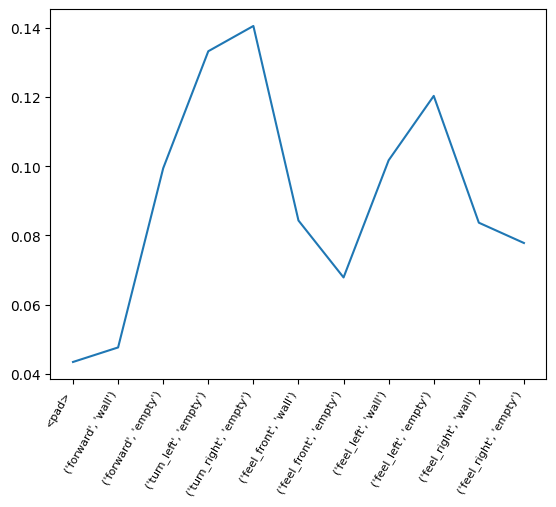

In [7]:
# La distribution de probabilité
# ce qui correspond à la prédiction du modèle pour le prochain token
# Cette distribution est calculée avec la fonction softmax et dépand de la température
plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())

## Output
Ce que le modèl sort est très variable si nous ne fixons pas la seed. Le modèl propose une distribution corespondant à l'initialisation de ses poids (aléatoirement).

## Appliquation de la génération
Avec notre premier output nous pouvons demander à notre "agent" d'appliquer les actions des tokens pour vérifier si les prédictions sont bonne ou non. 
De manière évidente en début les prédictions ont que très peu de chance d'être bonne. Ce qui est normal l'agent doit découvrir son environement.


In [8]:
def run_token(tokens:torch.Tensor, env):
    """Applique toutes les actions des tokens

    Args:
        token (torch.Tensor): La sortie brut du modèle de prédiction
        env (env): L'environnement dans lequel on veut appliquer les actions

    Returns:
        list: La liste des actions
        list: La liste des outcomes
    """
    actions = []
    outcomes = []
    for tok in tokens:
        interaction:tuple|str = tokenizer.decode(tok.item())
        if interaction in ["<pad>"]: # Liste des tokens qui ne correspondent à aucune action
            continue
        actions.append(interaction[0]) # On ajoute l'action à la liste
        outcomes.append(env.outcome(actions[-1])) # On récupère l'outcome de l'action
    return actions, outcomes

In [9]:
tokens = log_tokens
actions, outcomes = run_token(tokens, env_test)
print("Les actions tirées de la génération du modèle")
print(actions)
print("Les outcomes réel de l'environnement")
print(outcomes)

Les actions tirées de la génération du modèle
['feel_left', 'turn_right', 'feel_front', 'turn_left', 'forward']
Les outcomes réel de l'environnement
['wall', 'empty', 'empty', 'empty', 'wall']


# Train
## Jeu de données
Pour entrainer le modèle, il nous faut des données. Nous pouvons récupérer les interactions que "l'agent" à fait.
### Traitement des interactions
Nous avons les actions et outcomes, nous devons les transformers en token. Il nous faut une taille de contexte pour que l'entrainement soit fixe (cela améliore les performances). Nous pouvons prendre une grande taille que nous comblerons par des \<pad\>

#### Transformation en token

In [10]:
def action_outcome_to_token(actions, outcomes):
    token = []
    for i in range(len(actions)):
        token.append(tokenizer.encode((actions[i], outcomes[i])))
    return token

print(f"\033[0;32mLes actions\033[0m {actions} \n\033[0;32met outcomes\033[0m {outcomes}")
seq_token = action_outcome_to_token(actions, outcomes)
print(f"\033[0;32mLes tokens déduit\033[0m {seq_token}")


Les actions ['feel_left', 'turn_right', 'feel_front', 'turn_left', 'forward'] 
et outcomes ['wall', 'empty', 'empty', 'empty', 'wall']
Les tokens déduit [7, 4, 6, 3, 1]


#### Création du data set

In [11]:
# Création du data set :
def create_data(tokens, context_lenght, padding, min = 1):
    """
    Create the data
    """
    sentences = []
    for range_cut in range(min, context_lenght + 1):
        print("range", range_cut)
        for i in range(0, len(tokens) - range_cut, 1):
            sentences.append(tokens[i:i + range_cut])
            sentences[-1] = sentences[-1] + [padding] * (context_lenght - len(sentences[-1]))
    return sentences

data_set = create_data(seq_token, 10, tokenizer.encode("<pad>"), min = 9)
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)
    # print(tokenizer.decode(i))
    # print()

range 9
range 10
Le data set


### Data set
Maintenant que le data set est créer nous pouvons utiliser pytorch pour gérer notre data train. (Nous mettons aussi les données sous forme de tensor)

In [12]:
class CustomDataSetTextGenByToken(Dataset):
    def __init__(self, token, context_lenght:int, id_pad:int=0, min:int = 1):
        """
        Creates a custom dataset
        """
        # assert context_lenght % 2 != 0, "context_lenght must be odd"
        # assert len(actions) == len(outcomes), "actions and outcomes must have the same length"
        assert context_lenght > 0, "context_lenght can't be negative or zero"

        self.context_lenght = context_lenght
        self.tokenizer = tokenizer
        self.dim_out = tokenizer.size_vocab
        self.token = token
        self.padding = id_pad
        self.min = min
        self.data = self.create_data()

    # Fonction vue précédament
    def create_data(self):
        """
        Create the data
        """
        sentences = []
        for range_cut in range(self.min, self.context_lenght +1):
            for i in range(0, len(self.token) + 1 - range_cut, 1):
                sentences.append(self.token[i:i + range_cut])
                sentences[-1] = sentences[-1] + \
                                [self.padding] * (self.context_lenght - len(sentences[-1]))
        if len(sentences) == 0:
            sentences = [self.token + [self.padding] * (self.context_lenght - len(self.token))]
        
        print("debug")
        print(sentences)
        return sentences

    def __len__(self):
        """
        Get the length of the dataset
        :return: length
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the index idx

        :param idx: index
        :return: x
        """
        return torch.tensor(self.data[idx])
    
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=10,
    min=1)
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)


debug
[[7, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4, 0, 0, 0, 0, 0, 0, 0, 0, 0], [6, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [7, 4, 0, 0, 0, 0, 0, 0, 0, 0], [4, 6, 0, 0, 0, 0, 0, 0, 0, 0], [6, 3, 0, 0, 0, 0, 0, 0, 0, 0], [3, 1, 0, 0, 0, 0, 0, 0, 0, 0], [7, 4, 6, 0, 0, 0, 0, 0, 0, 0], [4, 6, 3, 0, 0, 0, 0, 0, 0, 0], [6, 3, 1, 0, 0, 0, 0, 0, 0, 0], [7, 4, 6, 3, 0, 0, 0, 0, 0, 0], [4, 6, 3, 1, 0, 0, 0, 0, 0, 0], [7, 4, 6, 3, 1, 0, 0, 0, 0, 0]]
Le data set
tensor([7, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([6, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([3, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([7, 4, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 6, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([6, 3, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([3, 1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([7, 4, 6, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 6, 3, 0, 0, 0, 0, 0, 0, 0])
tensor([6, 3, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([7, 4, 6, 3, 0, 0, 0, 0, 0

### Data loader
Nous faisons appel a pytorch pour créer un data Loader

In [13]:
data_loader_train = DataLoader(
    data_set,
    batch_size=1,
    shuffle=True,
    num_workers=8
)

### Loss et opti

In [14]:
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()

In [15]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

## Training

100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


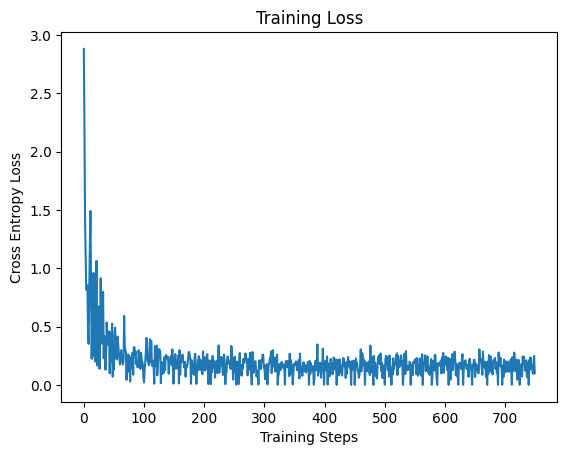

Text(0.5, 1.0, 'Entropy')

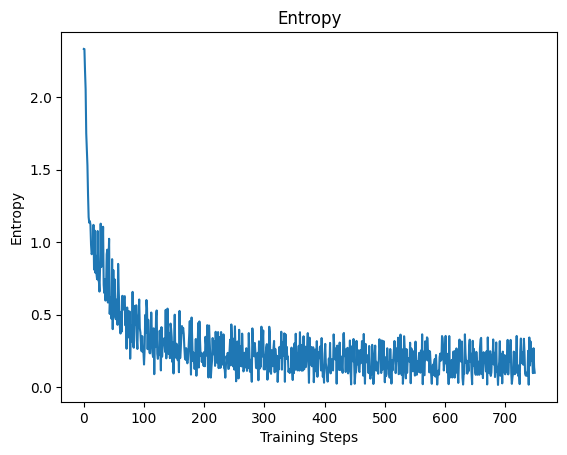

In [16]:
def train(lstm_generator, nb_epoch:int, optimizer, loss_fn, td:TokenDrop):
    # Monitor training loss and entropy
    training_loss_logger = []
    entropy_logger = []

    for epoch in tqdm(range(nb_epoch)):
        # Set LSTM generator model to training mode
        lstm_generator.train()
        steps = 0
        # Iterate over batches in training data loader
        for text in tqdm(data_loader_train, desc="Training", leave=False):
            # Transform text tokens using training transform and move to device
            bs = text.shape[0]
            
            # Randomly drop input tokens
            input_text = td(text[:, 0:-1])
            # output_text = text_tokens[:, 1:]
            input_text = text[:, 0:-1]
            output_text = text[:, 1:]
            
            # Initialize the memory buffers
            hidden = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            memory = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            
            # Forward pass through the LSTM generator
            pred, hidden, memory = lstm_generator(input_text, hidden, memory)

            # Calculate loss
            loss = loss_fn(pred.transpose(1, 2), output_text)
            
            # Zero gradients, perform backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log training loss
            training_loss_logger.append(loss.item())
            
            # Log entropy during training (for monitoring)
            with torch.no_grad():
                dist = Categorical(logits=pred)
                entropy_logger.append(dist.entropy().mean().item())
    return training_loss_logger, entropy_logger
 
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 50, opti, loss_fct, td=td)
# Display training loss and entropy
plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
# plt.show()

In [17]:
# Fonction en cour de test ...
def generate_sentence_with_env(lstm_generator, input_tokens, env_apply):
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Generate text
        good = 0
        bad = 0
        for i in range(100): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)
            
            if input_tokens.item() != tokenizer.encode("<pad>"):
                pred_out = tokenizer.decode(input_tokens.item())[1]
                real_out = env_apply.outcome(tokenizer.decode(input_tokens.item())[0])
                env_apply.save_world(path="imgToGif2")
                input_tokens = torch.tensor(tokenizer.encode((tokenizer.decode(input_tokens.item())[0], real_out))).reshape(1, -1)
                if real_out == pred_out:
                    good += 1
                else:
                    bad += 1
               

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())
            
            # Check for end-of-sentence token
            if input_tokens.item() == tokenizer.encode(('forward', 'empty')): # Si le token est ('forward', 'empty') on s'arrête
                break
        print(f"good : {good} bad : {bad}")
    return log_tokens, data_pred

# Boucle
Maintenant que nous avons vue toutes les étapes, nous pouvons tenter de faire un modèle qui comprends l'environement !  
Il est important de noté qu'il n'y a aucune volonté de faure un certain chemin. Le modèle peut tout a fait apprendre "forward", "wall" en boucle.

In [18]:
# Historique des actions et outcomes
all_actions, all_outcomes = [], []
actions = ['forward']
outcomes = [env_test.outcome('forward')]
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()
list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

<pad>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, ('forward', 'wall'): 1, ('forward', 'empty'): 2, ('turn_left', 'empty'): 3, ('turn_right', 'empty'): 4, ('feel_front', 'wall'): 5, ('feel_front', 'empty'): 6, ('feel_left', 'wall'): 7, ('feel_left', 'empty'): 8, ('feel_right', 'wall'): 9, ('feel_right', 'empty'): 10}


Le prompt [7, 4, 6, 3, 1]
('feel_left', 'wall')
('turn_right', 'empty')
('feel_front', 'empty')
('turn_left', 'empty')
('forward', 'wall')



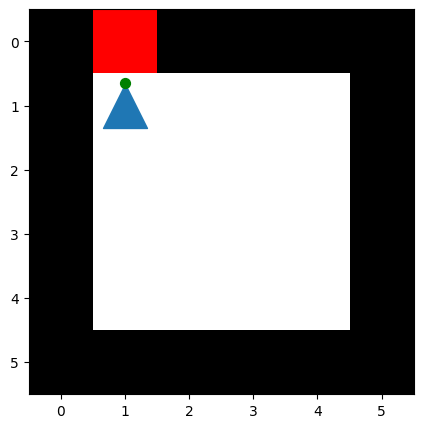

 Génération du modèle :
('turn_right', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
('feel_right', 'wall')
('turn_left', 'empty')
('forward', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_right', 'wall')
('feel_right', 'wall')
('turn_right', 'empty')
('feel_right', 'empty')
('feel_right', 'empty')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_left', 'empty')
('forward', 'empty')
Les vrai outcomes 
['empty', 'empty', 'empty', 'empty', 'empty', 'wall', 'wall', 'wall', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty']
debug
[[4, 10, 10, 10, 3, 1, 5, 7, 10, 10, 0], [10, 10, 10, 3, 1, 5, 7, 10, 10, 4, 0], [10, 10, 3, 1, 5, 7, 10, 10, 4, 10, 0], [10, 3, 1, 5, 7, 10, 10, 4, 10, 10, 0], [3, 1, 5, 7, 10, 10, 4, 10, 10, 4, 0], [1, 5, 7, 10, 10, 4, 10, 10, 4, 8, 0], [5, 7, 10, 10, 4, 10, 10, 4, 8, 3, 0], [7, 10, 10, 4, 10, 10, 4, 8, 3, 2, 0], [4, 10, 10, 10, 3, 1, 5, 7, 10, 10, 4], [10, 10, 10, 3, 1, 5, 7, 10, 10, 4, 10], [10, 10, 3,

100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


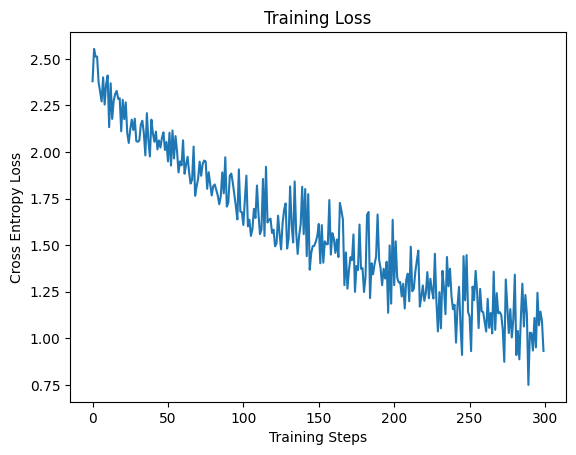

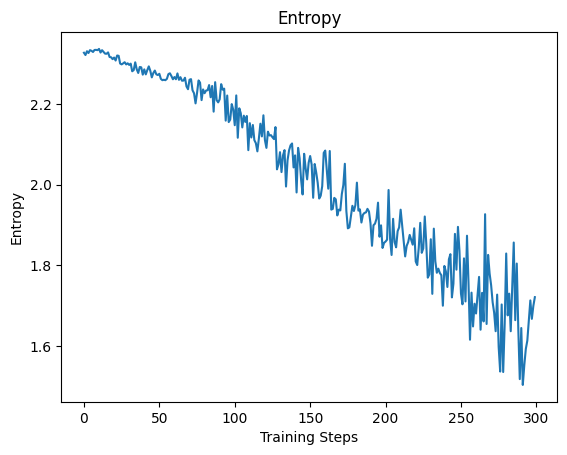

In [19]:
input_tokens = seq_token[-10:]
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()
env_test.display_world()
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred = generate_sentence(lstm_generator, input_tokens)
print("\033[0;32m Génération du modèle :\033[0m")
for i in log_tokens:
    print(tokenizer.decode(i.item()))

actions, outcomes = run_token(log_tokens, env_test)
print(f"\033[0;32mLes vrai outcomes\033[0m \n{outcomes}")
all_actions += actions
all_outcomes += outcomes

seq_token = action_outcome_to_token(all_actions, all_outcomes)
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=11,
    min=10)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [20]:
for i in data_loader_train:
    print(i)

tensor([[10,  3,  1,  5,  7, 10, 10,  4, 10, 10,  4]])
tensor([[10, 10,  3,  1,  5,  7, 10, 10,  4, 10, 10]])
tensor([[10, 10,  3,  1,  5,  7, 10, 10,  4, 10,  0]])
tensor([[10, 10, 10,  3,  1,  5,  7, 10, 10,  4, 10]])
tensor([[ 4, 10, 10, 10,  3,  1,  5,  7, 10, 10,  4]])
tensor([[ 5,  7, 10, 10,  4, 10, 10,  4,  8,  3,  0]])
tensor([[ 4, 10, 10, 10,  3,  1,  5,  7, 10, 10,  0]])
tensor([[ 5,  7, 10, 10,  4, 10, 10,  4,  8,  3,  2]])
tensor([[10, 10, 10,  3,  1,  5,  7, 10, 10,  4,  0]])
tensor([[ 3,  1,  5,  7, 10, 10,  4, 10, 10,  4,  8]])
tensor([[ 1,  5,  7, 10, 10,  4, 10, 10,  4,  8,  0]])
tensor([[ 1,  5,  7, 10, 10,  4, 10, 10,  4,  8,  3]])
tensor([[ 7, 10, 10,  4, 10, 10,  4,  8,  3,  2,  0]])
tensor([[ 3,  1,  5,  7, 10, 10,  4, 10, 10,  4,  0]])
tensor([[10,  3,  1,  5,  7, 10, 10,  4, 10, 10,  0]])


In [21]:
raise Exception("Fin du programme")

Exception: Fin du programme

# Autre boucle

In [39]:
# Fonction en cour de test ...
def generate_sentence_with_env(lstm_generator, input_tokens, env_apply, tokenizer):
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Generate text
        good = 0
        bad = 0
        for i in range(100): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)
            
            if input_tokens.item() != tokenizer.encode("<pad>"):
                pred_out = tokenizer.decode(input_tokens.item())[1]
                real_out = env_apply.outcome(tokenizer.decode(input_tokens.item())[0])
                env_apply.save_world(path="imgToGif2")
                input_tokens = torch.tensor(tokenizer.encode((tokenizer.decode(input_tokens.item())[0], real_out))).reshape(1, -1)
                if real_out == pred_out:
                    good += 1
                else:
                    bad += 1
               

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())
            
            # Check for end-of-sentence token
            if input_tokens.item() == tokenizer.encode(('forward', 'empty')): # Si le token est ('forward', 'empty') on s'arrête
                break
        print(f"good : {good} bad : {bad}")
    return log_tokens, data_pred

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


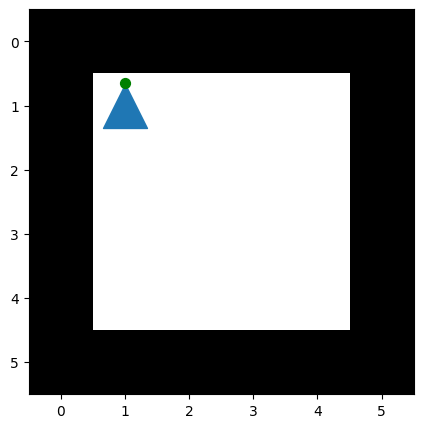

<pad>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, ('forward', 'wall'): 1, ('forward', 'empty'): 2, ('turn_left', 'empty'): 3, ('turn_right', 'empty'): 4, ('feel_front', 'wall'): 5, ('feel_front', 'empty'): 6, ('feel_left', 'wall'): 7, ('feel_left', 'empty'): 8, ('feel_right', 'wall'): 9, ('feel_right', 'empty'): 10}


In [40]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()
list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

In [41]:
actions = ['forward']
outcomes = [env_test.outcome('forward')]
seq_token = tokenizer.encode([(actions[-1], outcomes[-1])])
print(seq_token)
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()

[1]


Le prompt [8, 6, 9, 8, 9, 9, 9, 9, 9, 9]
('feel_left', 'empty')
('feel_front', 'empty')
('feel_right', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'wall')
('feel_right', 'wall')
('feel_right', 'wall')
('feel_right', 'wall')
('feel_right', 'wall')



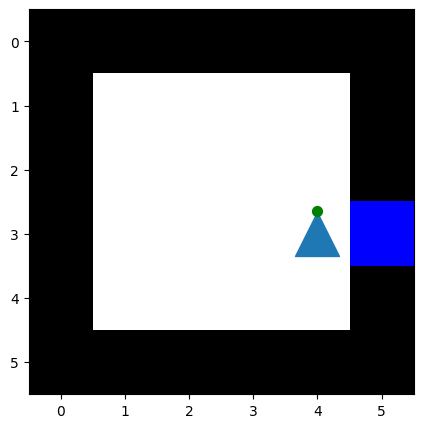

good : 11 bad : 1
test mm
[('feel_right', 'wall'), ('feel_right', 'wall'), ('feel_left', 'empty'), ('feel_right', 'wall'), ('feel_left', 'empty'), ('feel_right', 'wall'), ('feel_right', 'wall'), ('feel_left', 'empty'), ('feel_left', 'empty'), ('feel_front', 'empty'), ('feel_right', 'wall'), ('forward', 'empty')]
size compute :  25
debug
[[1, 1, 3, 8, 1, 9, 8, 8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 0], [1, 3, 8, 1, 9, 8, 8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 0], [3, 8, 1, 9, 8, 8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 0], [8, 1, 9, 8, 8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 8, 0], [1, 9, 8, 8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 8, 1, 0], [9, 8, 8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 8, 1, 8, 0], [8, 8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 8, 1, 8, 9, 0], [8, 8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 8, 1, 8, 9, 4, 0], [8, 8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 8, 1, 8, 9, 4, 1, 0], [8, 5, 9, 8, 9, 8, 4, 5, 3, 8, 1, 8, 1, 8, 1, 8, 9, 4, 1, 3, 0], [5, 9, 8, 

100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


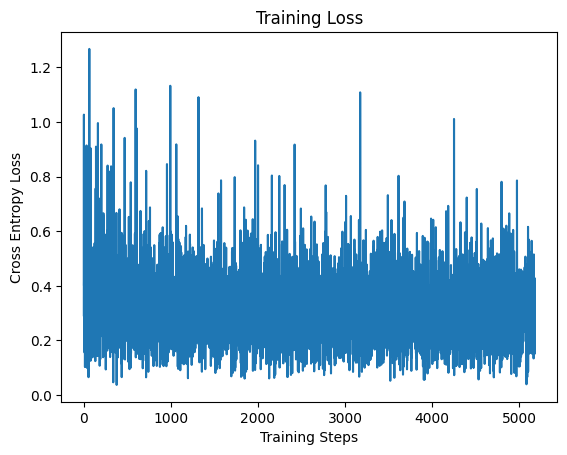

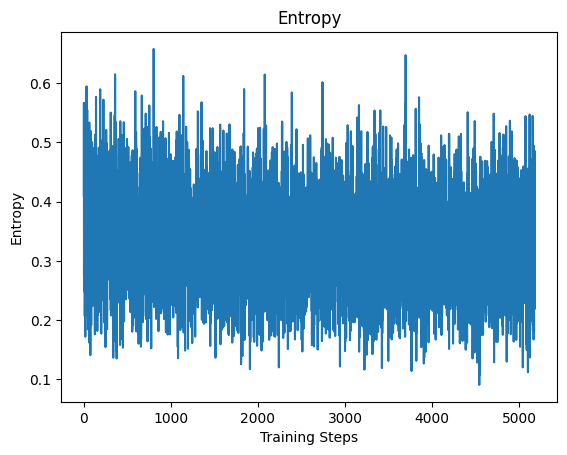

In [ ]:
input_tokens = seq_token[-10:]
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()
env_test.display_world()
input_tokens_tok = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred = generate_sentence_with_env(lstm_generator, input_tokens_tok, env_test, tokenizer)
# print("\033[0;32m Génération du modèle :\033[0m")
# for i in log_tokens:
#     print(tokenizer.decode(i.item()))

print('test mm')
no_pad = [token.item() for token in log_tokens if token.item() != tokenizer.encode("<pad>")]
print([tokenizer.decode(i) for i in no_pad])
print('size compute : ', len(log_tokens))

seq_token += no_pad
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=21,
    min=21)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
raise Exception("Fin du programme")

# Training loss
On peut se rendre compte que le modèle n'arrive pas a s'entrainner de cette manière.

In [ ]:
def generate_sentence_with_env(lstm_generator, input_tokens, env_apply):
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Generate text
        good = 0
        bad = 0
        for i in range(100): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)
            
            if input_tokens.item() != tokenizer.encode("<pad>"):
                pred_out = tokenizer.decode(input_tokens.item())[1]
                real_out = env_apply.outcome(tokenizer.decode(input_tokens.item())[0])
                input_tokens = torch.tensor(tokenizer.encode((tokenizer.decode(input_tokens.item())[0], real_out))).reshape(1, -1)
                if real_out == pred_out:
                    good += 1
                else:
                    bad += 1
               

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())
            
            # Check for end-of-sentence token
            if input_tokens.item() == tokenizer.encode(('forward', 'empty')): # Si le token est ('forward', 'empty') on s'arrête
                break
        print(f"good : {good} bad : {bad}")
    return log_tokens, data_pred
print(input_tokens)
generate_sentence_with_env(lstm_generator, input_tokens, env_test)

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

all_actions, all_outcomes = [], []
actions = ['forward']
outcomes = [env_test.outcome('forward')]
opti = optim.Adam(lstm_generator.parameters(), lr=0.0001)
loss_fct = nn.CrossEntropyLoss()
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=32,
    emb_size=32,
    num_layers=num_layers,
    dropout=0.25
)
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
seq_token = [tokenizer.encode(('forward', outcomes[-1]))]

In [ ]:
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()


In [ ]:
if len(seq_token) >= 10:
    input_tokens = seq_token[-10:]
else:
    input_tokens = seq_token
    
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()
env_test.display_world()
input_tokens_tensor = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred = generate_sentence_with_env(lstm_generator, input_tokens_tensor, env_test, tokenizer)

print([tokenizer.decode(i.item()) for i in log_tokens])

seq_token += [i.item() for i in log_tokens if i.item() != tokenizer.encode("<pad>")]
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=11,
    min=11)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
for i in data_loader_train:
    print(i)

# Autre idée

In [ ]:
# Not use interaction token

In [ ]:
def generate_sentence_no_end(lstm_generator, input_tokens):
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Generate text
        for i in range(20): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())

            # Check for end-of-sentence token
            # if input_tokens.item() == end_token:
            #     break
    return log_tokens, data_pred

In [ ]:
list_vocab = ['<pad>']
for act in env_test.get_actions():
    list_vocab.append(act)

for fb in env_test.get_outcomes():
    list_vocab.append(fb)

for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

In [ ]:
# Historique des actions et outcomes
all_actions, all_outcomes = [], []
actions = ['forward']
outcomes = [env_test.outcome('forward')]
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)


In [ ]:
class dataSetActFb(Dataset):
    def __init__(self, actions, outcomes, context_lenght, min, id_pad, tokenizer):
        self.actions = actions
        self.outcomes = outcomes
        self.tokenizer = tokenizer
        self.context_lenght = context_lenght
        self.min = min
        self.padding = id_pad
        self.data = self.create_data()
    
    def create_data(self):
        """
        Create the data
        """
        interaction = []
        for i in range(len(self.actions)):
            interaction += self.tokenizer.encode([self.actions[i], self.outcomes[i]])
        print("first debug")
        print(interaction)
        
        sentences = []
        for range_cut in range(self.min, self.context_lenght +1):
            for i in range(0, len(interaction) + 1 - range_cut, 1):
                sentences.append(interaction[i:i + range_cut])
                sentences[-1] = sentences[-1] + \
                                [self.padding] * (self.context_lenght - len(sentences[-1]))
        if len(sentences) == 0:
            sentences = [interaction + [self.padding] * (self.context_lenght - len(interaction))]
        
        print("debug")
        print(sentences)
        return sentences
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

actions, outcomes = [], []

for i in range(100):
    actions.append(str(np.random.choice(env_test.get_actions())))
    outcomes.append(env_test.outcome(actions[-1]))


In [ ]:
# Train 
data_set = dataSetActFb(
    actions=actions,
    outcomes=outcomes,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=50,
    min=49,
    tokenizer=tokenizer)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
from environnement.environnement3Str import Environnement3

env_test = Environnement3()
print(env_test.outcome('a'))
print(env_test.outcome('b'))

actions, outcomes = [], []
for i in range(100):
    actions.append(str(np.random.choice(env_test.get_actions())))
    outcomes.append(env_test.outcome(actions[-1]))
    
tokenizer = SimpleTokenizerV1(vocab={'<pad>': 0, 'a': 1, 'b': 2, 'x': 3, 'y': 4})

In [ ]:
# Train
data_set = dataSetActFb(
    actions=actions,
    outcomes=outcomes,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=50,
    min=49,
    tokenizer=tokenizer)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

lstm_generator = LSTM_GenText(
    num_emb=tokenizer.size_vocab,
    hidden_size=16,
    emb_size=16,
    num_layers=2,
    dropout=0.1
)
    

opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
raise NotImplementedError
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()
env_test.display_world()
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred = generate_sentence_no_end(lstm_generator, input_tokens)
print("\033[0;32m Génération du modèle :\033[0m")
for i in log_tokens:
    print(tokenizer.decode(i.item()))

actions, outcomes = run_token(log_tokens, env_test)
print(f"\033[0;32mLes vrai outcomes\033[0m \n{outcomes}")
all_actions += actions
all_outcomes += outcomes

seq_token = action_outcome_to_token(all_actions, all_outcomes)


In [ ]:
raise Exception
# Je vais considérer que nous avons une seul séquence (ce qui est en soit le cas)
# Pour l'entrainement je vais cacher certain token de la séquence et demander au modèle de les prédire
# Je vais ensuite comparer les prédictions du modèle avec les vrais tokens caché
# Pour cela je vais utiliser un mask qui va cacher les tokens

# Pour les tokens je vais d'abord essayer en reprenant un token pour chaque action et outcome
# Et non les interactions


In [ ]:
list_vocab = ['<pad>']
for act in env_test.get_actions():
    list_vocab.append(act)

for fb in env_test.get_outcomes():
    list_vocab.append(fb)


for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

In [ ]:
# Je vais reprendre le tokenDrop

In [ ]:
class TokenDrop(nn.Module):
    def __init__(self, prob=0.1, pad_token=0, num_special=1):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [ ]:
# Génetation d'une séquence
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

all_actions, all_outcomes = [], []
actions = ['forward']
outcomes = [env_test.outcome('forward')]
sequence = actions + outcomes

for i in range(100):
    actions.append(str(np.random.choice(env_test.get_actions())))
    outcomes.append(env_test.outcome(actions[-1]))
    sequence += [actions[-1], outcomes[-1]]
    
print(f"\033[0;32mLa séquence\033[0m {sequence}")

seq_token = torch.tensor(tokenizer.encode(sequence))


data = []

for i in range(10):
    tmp = td(seq_token)
    data.append(tmp)

In [ ]:
class SimpleDataSet(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

data_set = SimpleDataSet(data)
data_loader_train = DataLoader(
    data_set,
    batch_size=1,
    shuffle=True,
    num_workers=8
)

In [ ]:
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)

In [ ]:
train(lstm_generator, 20, opti, loss_fct, td)

In [ ]:
def train_without_td(lstm_generator, nb_epoch:int, optimizer, loss_fn):
    # Monitor training loss and entropy
    training_loss_logger = []
    entropy_logger = []

    for epoch in tqdm(range(nb_epoch)):
        # Set LSTM generator model to training mode
        lstm_generator.train()
        steps = 0
        # Iterate over batches in training data loader
        for text in tqdm(data_loader_train, desc="Training", leave=False):
            # Transform text tokens using training transform and move to device
            bs = text.shape[0]
            # output_text = text_tokens[:, 1:]
            input_text = text[:, 0:-1]
            output_text = text[:, 1:]
            
            # Initialize the memory buffers
            hidden = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            memory = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            
            # Forward pass through the LSTM generator
            pred, hidden, memory = lstm_generator(input_text, hidden, memory)

            # Calculate loss
            loss = loss_fn(pred.transpose(1, 2), output_text)
            
            # Zero gradients, perform backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log training loss
            training_loss_logger.append(loss.item())
            
            # Log entropy during training (for monitoring)
            with torch.no_grad():
                dist = Categorical(logits=pred)
                entropy_logger.append(dist.entropy().mean().item())
    return training_loss_logger, entropy_logger
 
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train_without_td(lstm_generator, 50, opti, loss_fct)
# Display training loss and entropy
plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()